In [101]:
%matplotlib inline

import json
import logging
from pathlib import Path
import random
import tarfile
import tempfile
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torchvision
import torchvision.transforms as transforms

In [102]:
data = pd.read_csv('/kaggle/input/flickr8k/captions.txt')

In [103]:
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [104]:
data.shape

(40455, 2)

In [105]:
data['click'] = pd.Series(np.random.randint(0, 10, (1, data.shape[0])).flatten())

In [106]:
data.head()

,image,caption,click
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,2
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,6
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,8
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,4
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,5


In [107]:
from PIL import Image

transform = transforms.Compose([
    torchvision.transforms.Resize(size=(32, 32)), # посмотреть размеры
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


images = [[
    transform(Image.open(
        "/kaggle/input/flickr8k/Images" + "/" + data.loc[i, "image"]
    ).convert("RGB")), data.loc[i, "click"]]
    for i in range(int(data.shape[0] / 10))
]


In [108]:

batch_size = 4

trainloader = torch.utils.data.DataLoader(images, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

classes = ('0','1', '2', '3', '4',
           '5', '6', '7', '8', '9')

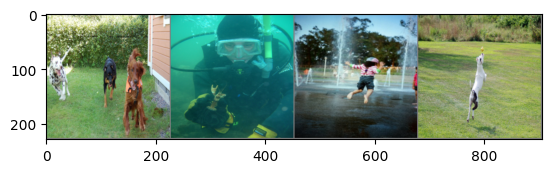

7     7     2     4    


In [112]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [113]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [114]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [115]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

#         print(inputs)
#         print('-----')
#         print(labels)
#         break

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x44944 and 400x120)

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        a, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')